In [2]:
import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import numpy as np
import matplotlib.pyplot as plt
import cv2

import torch
from torch.autograd import Function
import torchvision
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute, IBMQ
from qiskit.visualization import *

import random
from scipy.optimize import minimize

import pandas as pd

In [3]:
provider = IBMQ.load_account()

C:\Users\trongduong\Anaconda3\envs\QML\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


## Class of Autoencoder
Args:

    n_qubits: number of qubits that store compressed data
    
    k_qubits: number of trash/reference qubits (n+k = number of data qubits)
    
    layers: number of PQC layers 
    
Attributes:

    latent: latent state of n qubits
    
    trash: discarded qubits after encoding
    
    ref: reference qubits (in state '0' by default) used for SWAP test
    
    recon_ref: reference qubits for reconstruction
    
    ancillas, classical regs...
    
  
Methods:

    initialize_state_from_data(data): create unitary that prepares the (normalized) data sample
    
    create_PQC(): return a PQC architecture
    
    SWAP_test(): perform SWAP test between trash state and reference state after encoding phase
    
    insert_inverse_PQC(): add the inverse of the PQC above
    
    reconstruct(): create a full autoencoder including data initialization, encoding, and decoding
    
    run(thetas): execute the circuit with fixed parameters
    
    draw(): draw the main circuit

In [34]:
class AutoencoderQuantumCircuit():
    """ 
    This class provides an interface for interaction 
    with the quantum autoencoder
    """
    
    def __init__(self, n_qubits, k_qubits, layers, ansatz_id=None, backend=provider.get_backend("ibmq_qasm_simulator"), shots=1000):
        '''
        n_qubits: number of qubits that store compressed data
        k_qubits: number of trash qubits
        '''
        ## Basic attributes
        self.k_qubits = k_qubits
        self.n_qubits = n_qubits
        self.layers = layers
        self.data_qubits = list(range(self.n_qubits + self.k_qubits))
        #self.test = test
        
        ## PQC attributes
        self.theta = None
        self._PQC = None
        
        ## Reconstruction attributes
        self._recon_ref = None
        self._data_cr = None
        self._PQC_inverse = None
        
        ## SWAP attribute
        self._ref = None
        self._test_ancilla = None
        self._test_cr = None    

        ## Experiment attributes
        self.backend = backend
        self.shots = shots
                
        # --- Circuit definition ---
        self._latent = QuantumRegister(self.n_qubits, name='latent')
        self._trash = QuantumRegister(self.k_qubits, name='trash')
        self._circuit = QuantumCircuit(self._latent, self._trash)
        
    def initialize_state_from_data(self,init_data=None, return_initializer=False):
        '''
        Initialize a quantum state that corresponds to the data sample. The sample must be in 1-D numpy array.
        Can additionally return an initializer object
        '''
        if init_data is None:
            return
        assert type(init_data) == np.ndarray
        desired_vector = init_data[:]
        desired_vector = desired_vector / np.linalg.norm(desired_vector)
        self._initializer = QuantumCircuit(len(self.data_qubits), name='amplitude_encoder')
        self._initializer.initialize(desired_vector, self._initializer.qregs)
        #self._circuit.append(self._initializer.to_instruction(), self._latent[:] + self._trash[:])
        #self.draw()
        #self._circuit.initialize(desired_vector, [self._latent, self._trash])       
        if return_initializer == True:
            return qiskit.extensions.Initialize(desired_vector)
        return
    
    def create_PQC(self, ansatz_id=None):
        '''
        Implement PQC architectures in the following paper:
        '''
        if ansatz_id is None:
            ansatz_id = 9
        width = len(self.data_qubits)
        self._PQC = QuantumCircuit(width)
        
        if ansatz_id == 6:      
            num_params = (width*width + 3*width) * self.layers
            self.theta = qiskit.circuit.ParameterVector('θ', num_params)
            theta_iter = iter(self.theta)     

            for layer in range(self.layers):
                for i in self.data_qubits:
                    self._PQC.rx(next(theta_iter), i)
                for i in self.data_qubits:
                    self._PQC.rz(next(theta_iter), i)

                for i in self.data_qubits:
                    for j in self.data_qubits:
                        if j != i:
                            self._PQC.crx(next(theta_iter), i, j)

                for i in self.data_qubits:
                    self._PQC.rx(next(theta_iter), i)
                for i in self.data_qubits:
                    self._PQC.rz(next(theta_iter), i)    
                     
        elif ansatz_id == 9:
            num_params = width * self.layers
            self.theta = qiskit.circuit.ParameterVector('θ', num_params)
            theta_iter = iter(self.theta) 
            
            for layer in range(self.layers):
                self._PQC.h(self.data_qubits)
                for i in self.data_qubits[:-1]:
                    self._PQC.cz(i,i+1)
                for i in self.data_qubits:
                    self._PQC.rx(next(theta_iter), i)
            
        #print("PQC PQC circuit = ")
        #print(self._PQC.draw())
        
        self._PQC_gate = self._PQC.to_gate(label='PQC gate') 
        
        return 
            
    def SWAP_test(self, init_data=None, thetas=None, ansatz_id=None):
        
        #print("SWAP ansatz_id = {}".format(ansatz_id))
        
        self._ref = QuantumRegister(self.k_qubits, name='ref')
        self._test_ancilla = QuantumRegister(1, name='testancilla')
        self._test_cr = ClassicalRegister(1, name='testmeasure')
        self._circuit.add_register(self._ref, self._test_ancilla, self._test_cr)
        
        ## Prepare data and PQC architecture
        #print("SWAP init_data = {}".format(init_data))
        self.initialize_state_from_data(init_data)
        self._circuit.append(self._initializer.to_instruction(), self._latent[:] + self._trash[:])
        
        self.create_PQC(ansatz_id)
        self._circuit.append(self._PQC_gate, self._latent[:] + self._trash[:]) 
        
        ## Set up SWAP test
        self._circuit.h(self._test_ancilla)
        for i in range(len(self._trash)):
            self._circuit.cswap(self._test_ancilla, self._trash[i], self._ref[i])
        self._circuit.h(self._test_ancilla)
        self._circuit.measure(self._test_ancilla, self._test_cr)
        #self.draw()
        
        ## EXECUTE SWAP TEST
        probabilities = self.run(thetas)
        #print("SWAP probabilities = {}".format(probabilities))
        
        for prob in probabilities:
            if '0' not in prob:
                prob['0'] = 0
            if '1' not in prob:
                prob['1'] = 0
                
        calculate_f = lambda prob: prob['0'] - prob['1']
        fidelities = np.array(list(map(calculate_f, probabilities)))
        
        return fidelities
    
    def Hadamard_test(self, init_data=None, thetas=None, ansatz_id=None):
        self._ref = QuantumRegister(self.k_qubits, name='ref')
        self._test_ancilla = QuantumRegister(1, name='testancilla')
        self._test_cr = ClassicalRegister(1, name='testmeasure')
        self._discard = ClassicalRegister(self.n_qubits, name='testdiscard')
        self._circuit.add_register(self._ref, self._test_ancilla, self._test_cr, self._discard)   
        
        self._circuit.h(self._test_ancilla)
        
        # Prepare controlled data initializer and controlled PQC
        initializer =  self.initialize_state_from_data(init_data, return_initializer=True)     
        controlled_initializer = initializer.gates_to_uncompute().decompose().decompose().inverse().to_gate(label='amplitude_encoder').control()
        self._circuit.append(controlled_initializer, self._test_ancilla[:] + self._latent[:] + self._trash[:])
        
        self.create_PQC(ansatz_id)
        control_PQC = self._PQC_gate.control()
        self._circuit.append(control_PQC, self._test_ancilla[:] + self._latent[:] + self._trash[:]) 
        
        self._circuit.h(self._test_ancilla)
        
        self._circuit.measure(self._latent, self._discard)
        self._circuit.measure(self._test_ancilla, self._test_cr)
        #self.draw()
        
        ## EXECUTE HADAMARD TEST
        probabilities = self.run(thetas)
        #print("Hadamard probabilities = {}".format(probabilities))

        #calculate_distance = lambda prob: sum([val for key,val in prob.items() if key[-1]=='0']) - sum([val for key,val in prob.items() if key[-1]=='1']) 
        calculate_distance = lambda prob: sum([val * (-1)**int(key[-1]) for key,val in prob.items()])
        fidelities = np.array(list(map(calculate_distance, probabilities)))
        
        return fidelities
        
        
    def insert_inverse_PQC(self):
        #self._PQC_gate =
        self._recon_ref = QuantumRegister(self.k_qubits, name='reconref')
        self._data_cr = ClassicalRegister(len(self.data_qubits))
        self._circuit.add_register(self._recon_ref, self._data_cr)
        
        self._PQC_inverse = self._PQC_gate.inverse()
        self._PQC_inverse.label = 'PQC_dg'
        self._circuit.append(self._PQC_inverse, self._latent[:] + self._recon_ref[:])
        #self._circuit.measure(self._latent[:] + self._recon_ref[:], self._data_cr)
        return
    
    def reconstruct(self, init_data, thetas, ansatz_id=None):
        
        ## Prepare data and PQC architecture
        #print("SWAP init_data = {}".format(init_data))
        self.initialize_state_from_data(init_data)
        self._circuit.append(self._initializer.to_instruction(), self._latent[:] + self._trash[:])
        
        self.create_PQC(ansatz_id)
        self._circuit.append(self._PQC_gate, self._latent[:] + self._trash[:])        
        self.insert_inverse_PQC()
        
        self._circuit.measure(self._latent[:] + self._recon_ref[:], self._data_cr)
        self.draw()
        probabilities = self.run(thetas)
        return probabilities
    
    def run(self, thetas=None):
        
        if thetas is not None:
            #thetas = [thetas]
            #print("RUN thetas shape = {}".format(np.array(thetas).shape))
            bound_circuits = [self._circuit.bind_parameters({self.theta: theta}) for theta in thetas]
            
        else:
            bound_circuits = [self._circuit]
        #print(bound_circuits[0].draw())
            
        job = qiskit.execute(bound_circuits,
                             backend = self.backend,
                             shots = self.shots)

        #bin_convert = lambda bitstring: int(bitstring.replace(" ", ""), 2)
        probabilities = []
        
        for idx,circuit in enumerate(bound_circuits):
            #print(circuit.draw())
            result = job.result().get_counts(idx)
            
            prob = {state:count/self.shots for state,count in result.items()}
            probabilities.append(prob)
        #print("RUN probabilities = {}".format(probabilities))
        self.reset_circuit()
        #print("RUN reset")
        return np.array(probabilities)
            

    def draw(self):
        print(self._circuit.draw())
        
    def measure(self, thetas=None, scope='all'): 
        if scope == 'all':
            n = self._circuit.num_qubits
            measure_cr = ClassicalRegister(n)
            self._circuit.add_register(measure_cr)
            self._circuit.measure(self._circuit.qubits, measure_cr)
            probabilities = self.run(thetas)
        if scope == 'latent':
            n = self.n_qubits
            measure_cr = ClassicalRegister(n)
            self._circuit.add_register(measure_cr)
            self._circuit.measure(self._circuit.qubits[:n], measure_cr)
            probabilities = self.run(thetas)
        return probabilities
    
    def reset_circuit(self):
        self._circuit = QuantumCircuit(self._latent, self._trash)
        return
    

In [12]:
# TESTING
import time

t0 = time.time()
backend = qiskit.Aer.get_backend('qasm_simulator')
shots=10000

init_data = np.zeros(shape=16)
init_data[14]= 1
print("Input state: {}".format(init_data))

theta1 = [0]*84
theta2 = [1]*84
thetas = [theta1,theta2]

circuit = AutoencoderQuantumCircuit(2,2,layers=3, backend=backend, shots=shots)
fidelities = circuit.SWAP_test(init_data,thetas,ansatz_id=6)
fidelities = circuit.Hadamard_test(init_data,thetas,ansatz_id=6)

t1 = time.time()

print("Fidelities: {}".format(fidelities))
print(t1-t0)

Input state: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
Fidelities: [-0.0158 -0.0278]
3.867149591445923


## Class of Hybrid Layer
Custom forward() and backward() methods to make training compatible with Pytorch

Issue:

    Cannot pass a torch.tensor directly to quantum circuit --> Use of cuda is not effective. 
    
    backward() requires gradients w.r.t. lots of circuit parameters --> Extremely slow in Aer (local) simulation
    
    Error raised if using IBMQ (cloud) simulation: 'Unable to retrieve result for job 60106fe2e537cf05b5a97cda. Job has failed: The number of experiments in the Qobj (352) is higher than the number of experiments supported by the device (300). Error code: 1102.'

In [33]:
class HybridFunction(Function):
    """ Hybrid quantum - classical function definition """
    
    @staticmethod
    def forward(ctx, batch_data, num_qubits, params, ansatz_id, test, autoencoder, shift):
        """ Forward pass computation """
        #print("FW input = {}".format(input.tolist()))
        
        ctx.batch_data = batch_data
        ctx.num_qubits = num_qubits
        ctx.ansatz_id = ansatz_id
        ctx.test = test
        ctx.shift = shift
        ctx.autoencoder = autoencoder
        batch_data_array = np.array(batch_data.cpu()).reshape(-1,2**num_qubits)
        #print("FW batch_data = {}".format(batch_data_array.shape))
        fidelities = []
        for init_data in batch_data_array:
            #print("FW init_data = {}".format(init_data.shape))
            #print("FW params = {}".format(params.shape))
            if ctx.test == 'Hadamard':
                fidelities.append(ctx.autoencoder.Hadamard_test(init_data, params.tolist(), ctx.ansatz_id))
            elif ctx.test == 'SWAP':
                fidelities.append(ctx.autoencoder.SWAP_test(init_data, params.tolist(), ctx.ansatz_id))
            #print("FW fidelities = {}".format(fidelities))
            
        #print("FW fidelities = {}".format(fidelities))
        result = torch.tensor(fidelities).to(device)
        #print("FW expectation_z = {}".format(expectation_z))
        #print("FW result = {}".format(result))
        ctx.save_for_backward(params, result)
        
        return result
        
    @staticmethod
    def backward(ctx, grad_output):
        """ Backward pass computation """
        #print("BW grad_output = {}".format(grad_output.shape))
        params, result = ctx.saved_tensors
        params_list = np.array(params.tolist())
        batch_data_array = np.array(ctx.batch_data.cpu()).reshape(-1,2**ctx.num_qubits)
        #print("BW batch_data_array = {}".format(batch_data_array.shape))
        
        
        num_samples, num_params = params_list.shape ## num_samples = 1
        #print("BW num_samples, num_params = {} and {}".format(num_samples, num_params))
        shift_params = np.zeros(shape=(num_samples, num_params, 2, num_params))
        gradients = []
        
        for sample_idx in range(num_samples):
            for param_idx in range(num_params):
                shift_params[sample_idx, param_idx, 0] = params_list[sample_idx] ## d-dim parameter shifted right at param_idx
                shift_params[sample_idx, param_idx, 0, param_idx] += ctx.shift
                
                shift_params[sample_idx, param_idx, 1] = params_list[sample_idx] ## d-dim parameter shifted left at param_idx
                shift_params[sample_idx, param_idx, 1, param_idx] -= ctx.shift
                
        shift_params = shift_params.reshape(-1,num_params)
        #print("BW shift_params = {}".format(shift_params.shape))
        
        #shift_fidelities = []
        for init_data in batch_data_array:
            if ctx.test == 'Hadamard':
                shift_fidel = ctx.autoencoder.Hadamard_test(init_data, shift_params.tolist(), ctx.ansatz_id)
            elif ctx.test == 'SWAP':
                shift_fidel = ctx.autoencoder.SWAP_test(init_data, shift_params.tolist(), ctx.ansatz_id)
            #print("BW shift_fidel type = {}".format(type(shift_fidel)))
            #print("BW shift_fidel = {}".format(shift_fidel))
            
            #shift_fidelities.append(shift_f)
            grad = shift_fidel[0::2] - shift_fidel[1::2]
            grad = grad.reshape(num_params)
            gradients.append(grad)
            #print("BW grad = {}".format(grad))
        gradients = np.array(gradients) / 2
        gradients = torch.tensor(gradients.reshape(ctx.batch_data.shape[0], num_params)).to(device)
        
        #print("BW gradients = {}".format(gradients.shape))
        return None, None, gradients.float() * grad_output.float(), None, None, None, None

class Hybrid(nn.Module):
    """ Hybrid quantum - classical layer definition """
    
    def __init__(self, n_qubits, k_qubits, layers, ansatz_id, test, backend, shots, shift):
        super(Hybrid, self).__init__()
        self.autoencoder = AutoencoderQuantumCircuit(n_qubits, k_qubits, layers, ansatz_id, backend=backend, shots=shots)
        self.shift = shift
        self.ansatz_id = ansatz_id
        self.test = test
        
        self.num_qubits = n_qubits + k_qubits
        if ansatz_id == 6:
            self.num_params = (self.num_qubits ** 2 + 3*self.num_qubits) * layers
        elif ansatz_id == 9:
            self.num_params = self.num_qubits * layers
        else:
            raise Exception("Invalid circuit ID")
        
        self.params = nn.Parameter(data=torch.rand((1,self.num_params), dtype=torch.float), requires_grad=True)
        
    def forward(self, batch_data):
        return HybridFunction.apply(batch_data, self.num_qubits, self.params, self.ansatz_id, self.test, self.autoencoder, self.shift)

In [31]:
class Net(nn.Module):
    def __init__(self, n_qubits, k_qubits, layers, ansatz_id=None, test='Hadamard', backend=provider.get_backend("ibmq_qasm_simulator"), shots=100, shift=np.pi / 2):
        super(Net, self).__init__()
        self.hybrid = Hybrid(n_qubits,k_qubits,layers,
                             ansatz_id, test,
                             backend=backend,
                             shots=shots,
                             shift=shift)

    def forward(self, x):
        #print("1: ", x.shape)
        x = self.hybrid(x.detach())
        #print("2: ", x.shape)
        return x

In [32]:
def FLoss(output, weight=None):
    if weight is None:
        weight = np.ones(len(output)) / len(output)
    else:
        assert type(weight) == np.ndarray
        assert weight.shape == (len(outputs),)
        assert sum(weight) == 1
        
    #print("FLoss output = {}".format(output))
    weight = torch.tensor(weight.reshape(len(output),1)).to(device)
    loss = 1 - torch.sum(output * weight)
    return loss

In [13]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True
#device = 'cpu'
print(device)

cuda:0


In [291]:
def train(n_qubits,k_qubits,layers,ansatz_id,test,path):
    data_dim = 6
    backend = qiskit.Aer.get_backend('qasm_simulator')
    shots = 1000
    shift = np.pi/2

    model = Net(n_qubits,k_qubits,layers, ansatz_id, test, backend, shots, shift).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    #loss_func = nn.NLLLoss()
    loss_func = FLoss

    epochs = 300
    loss_list = []
    min_loss = 1.

    model.train()
    
    for epoch in range(epochs):
        total_loss = []
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            #print(data.shape)
            # Forward pass
            output = model(data.to(device))
            # Calculating loss
            #print("TRAIN output = {}".format(output))
            #print("TRAIN target = {}".format(target))
            loss = loss_func(output)
            # Backward pass
            loss.backward()
            # Optimize the weights
            optimizer.step()

            total_loss.append(loss.item())
        loss_list.append(sum(total_loss)/len(total_loss))

        print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
            100. * (epoch + 1) / epochs, loss_list[-1]))

        if loss < min_loss:
            min_loss = loss
            torch.save(model.cpu().state_dict(), path)
            print("Model with loss = {} has been saved to {}".format(loss, path))

            
    return loss_list
    #torch.save(model.cpu().state_dict(), path)
    #print("Model has been saved to {}".format(path))

### Training set only includes 2 images of handwritten number 1 (MNIST)
because for using Adam (or any gradient-based) optimizer, computing partial derivative for every parameters requires circuit simulation, which takes from days to weeks. For illustration, we attempt to use a trivial dataset.

In [27]:
# Concentrating on the first 100 samples
n_samples = 2

transform  = transforms.Compose([transforms.Resize([8,8]),
                                 transforms.ToTensor(),
                                 transforms.ConvertImageDtype(torch.float64)])
#transform = transforms.Compose([transforms.ToTensor()])

X_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Leaving only labels 0 and 1 
# idx = np.append(np.where(X_train.targets == 0)[0][:n_samples], 
#                 np.where(X_train.targets == 1)[0][:n_samples])
idx = np.where(X_train.targets == 1)[0][:n_samples]

X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

train_loader = torch.utils.data.DataLoader(X_train, batch_size=32, shuffle=True)

In [28]:
n_samples = 50

X_test = datasets.MNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))

idx = np.append(np.where(X_test.targets == 0)[0][:n_samples], 
                np.where(X_test.targets == 1)[0][:n_samples])

X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

test_loader = torch.utils.data.DataLoader(X_test, batch_size=8, shuffle=True)

### Save models and losses

In [24]:
def create_path(n_qubits, k_qubits, layers, PQC_id, test, epochs):
    SAVE_DIR = r"C:\Users\trongduong\[QML Study]\saved_models"
    local_path = str(n_qubits)+'_'+str(k_qubits)+'_'+str(layers)+'layers_'+'id'+str(PQC_id)+'_'+test+'_'+str(epochs)+'epochs.pth'
    path = os.path.join(SAVE_DIR, local_path)
    return path

In [25]:
columns = ['n_qubits','k_qubits','layers','PQC_id', 'test', 'shots', 'shift', 'epochs', 'model_path', 'loss']
train_models = pd.DataFrame(columns=columns)

In [26]:
path = create_path(4,2,5,9,'SWAP',300)
train_models.loc[0] = [4,2,5,9,'SWAP',1000,np.pi/2,300,path,None]

path = create_path(4,2,5,9,'Hadamard',300)
train_models.loc[1] = [4,2,5,9,'Hadamard',1000,np.pi/2,300,path,None]

path = create_path(4,2,1,6,'SWAP',300)
train_models.loc[2] = [4,2,1,6,'SWAP',1000,np.pi/2,300,path,None]

path = create_path(4,2,1,6,'Hadamard',300)
train_models.loc[3] = [4,2,1,6,'Hadamard',1000,np.pi/2,300,path,None]

path = create_path(4,2,11,9,'SWAP',300)
train_models.loc[4] = [4,2,11,9,'SWAP',1000,np.pi/2,300,path,None]

path = create_path(4,2,11,9,'Hadamard',300)
train_models.loc[5] = [4,2,11,9,'Hadamard',1000,np.pi/2,300,path,None]

### Training model with 6 configs: $n = 4, k = 2$
    1. layers = 5, ansatz_id = 9, SWAP test
    2. layers = 5, ansatz_id = 9, Hadamard test
    3. layers = 1, ansatz_id = 6, SWAP test
    4. layers = 1, ansatz_id = 6, Hadamard test
    5. layers = 11, ansatz_id = 9, SWAP test
    6. layers = 11, ansatz_id = 9, Hadamard test

In [303]:
f = 'train_models.csv'

for idx,row in train_models.iterrows():
    print(row['model_path'])
    loss = train(row['n_qubits'], row['k_qubits'], row['layers'], row['PQC_id'], row['test'], row['model_path'])
    train_models['loss'][idx] = loss
    train_models.to_csv(f,index=False)

C:\Users\trongduong\[QML Study]\saved_models\4_2_5layers_id9_SWAP_300epochs.pth
Training [0%]	Loss: 0.7410
Model with loss = 0.741 has been saved to C:\Users\trongduong\[QML Study]\saved_models\4_2_5layers_id9_SWAP_300epochs.pth
Training [1%]	Loss: 0.7600
Training [1%]	Loss: 0.8040
Training [1%]	Loss: 0.7810
Training [2%]	Loss: 0.8300
Training [2%]	Loss: 0.7770
Training [2%]	Loss: 0.7700
Training [3%]	Loss: 0.7550
Training [3%]	Loss: 0.7760
Training [3%]	Loss: 0.8090
Training [4%]	Loss: 0.8240
Training [4%]	Loss: 0.8010
Training [4%]	Loss: 0.7840
Training [5%]	Loss: 0.7710
Training [5%]	Loss: 0.7720
Training [5%]	Loss: 0.7720
Training [6%]	Loss: 0.7930
Training [6%]	Loss: 0.7930
Training [6%]	Loss: 0.8010
Training [7%]	Loss: 0.8120
Training [7%]	Loss: 0.8150
Training [7%]	Loss: 0.7920
Training [8%]	Loss: 0.7600
Training [8%]	Loss: 0.7550
Training [8%]	Loss: 0.7630
Training [9%]	Loss: 0.8140
Training [9%]	Loss: 0.8280
Training [9%]	Loss: 0.8110
Training [10%]	Loss: 0.7650
Training [10%]

Training [90%]	Loss: 0.6960
Training [90%]	Loss: 0.7290
Training [91%]	Loss: 0.7240
Training [91%]	Loss: 0.7310
Training [91%]	Loss: 0.7360
Training [92%]	Loss: 0.7320
Training [92%]	Loss: 0.7370
Training [92%]	Loss: 0.7320
Training [93%]	Loss: 0.7320
Training [93%]	Loss: 0.7400
Training [93%]	Loss: 0.7610
Training [94%]	Loss: 0.7420
Training [94%]	Loss: 0.7190
Training [94%]	Loss: 0.7210
Training [95%]	Loss: 0.7450
Training [95%]	Loss: 0.7700
Training [95%]	Loss: 0.7230
Training [96%]	Loss: 0.6900
Training [96%]	Loss: 0.7250
Training [96%]	Loss: 0.7540
Training [97%]	Loss: 0.7210
Training [97%]	Loss: 0.7280
Training [97%]	Loss: 0.7300
Training [98%]	Loss: 0.7460
Training [98%]	Loss: 0.6980
Training [98%]	Loss: 0.7280
Training [99%]	Loss: 0.7240
Training [99%]	Loss: 0.7540
Training [99%]	Loss: 0.7220
Training [100%]	Loss: 0.7390
Training [100%]	Loss: 0.7410
C:\Users\trongduong\[QML Study]\saved_models\4_2_5layers_id9_Hadamard_300epochs.pth


C:\Users\trongduong\Anaconda3\envs\QML\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Training [0%]	Loss: 0.9500
Model with loss = 0.95 has been saved to C:\Users\trongduong\[QML Study]\saved_models\4_2_5layers_id9_Hadamard_300epochs.pth
Training [1%]	Loss: 0.9570
Training [1%]	Loss: 0.9920
Training [1%]	Loss: 0.9790
Training [2%]	Loss: 0.9210
Model with loss = 0.921 has been saved to C:\Users\trongduong\[QML Study]\saved_models\4_2_5layers_id9_Hadamard_300epochs.pth
Training [2%]	Loss: 0.9640
Training [2%]	Loss: 0.9740
Training [3%]	Loss: 0.9340
Training [3%]	Loss: 0.9570
Training [3%]	Loss: 0.9280
Training [4%]	Loss: 0.8920
Model with loss = 0.892 has been saved to C:\Users\trongduong\[QML Study]\saved_models\4_2_5layers_id9_Hadamard_300epochs.pth
Training [4%]	Loss: 0.9250
Training [4%]	Loss: 0.8960
Training [5%]	Loss: 0.9350
Training [5%]	Loss: 0.9470
Training [5%]	Loss: 0.9310
Training [6%]	Loss: 0.9380
Training [6%]	Loss: 0.9710
Training [6%]	Loss: 0.9670
Training [7%]	Loss: 0.9420
Training [7%]	Loss: 0.9750
Training [7%]	Loss: 0.9630
Training [8%]	Loss: 0.9490
Tr

Training [68%]	Loss: 0.7660
Training [68%]	Loss: 0.7760
Training [68%]	Loss: 0.8160
Training [69%]	Loss: 0.7990
Training [69%]	Loss: 0.7820
Training [69%]	Loss: 0.8110
Training [70%]	Loss: 0.7410
Model with loss = 0.741 has been saved to C:\Users\trongduong\[QML Study]\saved_models\4_2_5layers_id9_Hadamard_300epochs.pth
Training [70%]	Loss: 0.7640
Training [70%]	Loss: 0.7770
Training [71%]	Loss: 0.7610
Training [71%]	Loss: 0.7770
Training [71%]	Loss: 0.7990
Training [72%]	Loss: 0.8000
Training [72%]	Loss: 0.7960
Training [72%]	Loss: 0.7580
Training [73%]	Loss: 0.7540
Training [73%]	Loss: 0.7630
Training [73%]	Loss: 0.7730
Training [74%]	Loss: 0.7540
Training [74%]	Loss: 0.7800
Training [74%]	Loss: 0.7650
Training [75%]	Loss: 0.7660
Training [75%]	Loss: 0.7810
Training [75%]	Loss: 0.7610
Training [76%]	Loss: 0.7740
Training [76%]	Loss: 0.7880
Training [76%]	Loss: 0.8230
Training [77%]	Loss: 0.7790
Training [77%]	Loss: 0.7750
Training [77%]	Loss: 0.7670
Training [78%]	Loss: 0.8030
Traini

Training [41%]	Loss: 0.5500
Training [41%]	Loss: 0.5270
Training [42%]	Loss: 0.4960
Model with loss = 0.496 has been saved to C:\Users\trongduong\[QML Study]\saved_models\4_2_1layers_id6_SWAP_300epochs.pth
Training [42%]	Loss: 0.5360
Training [42%]	Loss: 0.5150
Training [43%]	Loss: 0.5350
Training [43%]	Loss: 0.4970
Training [43%]	Loss: 0.5050
Training [44%]	Loss: 0.5360
Training [44%]	Loss: 0.5380
Training [44%]	Loss: 0.5100
Training [45%]	Loss: 0.5200
Training [45%]	Loss: 0.4990
Training [45%]	Loss: 0.5040
Training [46%]	Loss: 0.5330
Training [46%]	Loss: 0.5310
Training [46%]	Loss: 0.5230
Training [47%]	Loss: 0.5360
Training [47%]	Loss: 0.5260
Training [47%]	Loss: 0.4900
Model with loss = 0.49 has been saved to C:\Users\trongduong\[QML Study]\saved_models\4_2_1layers_id6_SWAP_300epochs.pth
Training [48%]	Loss: 0.5430
Training [48%]	Loss: 0.4930
Training [48%]	Loss: 0.5060
Training [49%]	Loss: 0.4940
Training [49%]	Loss: 0.5210
Training [49%]	Loss: 0.5210
Training [50%]	Loss: 0.5250
T

Training [14%]	Loss: 0.8720
Training [15%]	Loss: 0.8750
Training [15%]	Loss: 0.8710
Training [15%]	Loss: 0.8680
Training [16%]	Loss: 0.8570
Training [16%]	Loss: 0.8770
Training [16%]	Loss: 0.8790
Training [17%]	Loss: 0.8500
Model with loss = 0.85 has been saved to C:\Users\trongduong\[QML Study]\saved_models\4_2_1layers_id6_Hadamard_300epochs.pth
Training [17%]	Loss: 0.8640
Training [17%]	Loss: 0.9050
Training [18%]	Loss: 0.9010
Training [18%]	Loss: 0.8960
Training [18%]	Loss: 0.8560
Training [19%]	Loss: 0.8470
Model with loss = 0.847 has been saved to C:\Users\trongduong\[QML Study]\saved_models\4_2_1layers_id6_Hadamard_300epochs.pth
Training [19%]	Loss: 0.8810
Training [19%]	Loss: 0.8950
Training [20%]	Loss: 0.8410
Model with loss = 0.841 has been saved to C:\Users\trongduong\[QML Study]\saved_models\4_2_1layers_id6_Hadamard_300epochs.pth
Training [20%]	Loss: 0.8390
Model with loss = 0.839 has been saved to C:\Users\trongduong\[QML Study]\saved_models\4_2_1layers_id6_Hadamard_300epoc

Training [92%]	Loss: 0.7670
Training [93%]	Loss: 0.7730
Training [93%]	Loss: 0.7690
Training [93%]	Loss: 0.7630
Training [94%]	Loss: 0.7580
Training [94%]	Loss: 0.7560
Training [94%]	Loss: 0.7620
Training [95%]	Loss: 0.7620
Training [95%]	Loss: 0.7430
Training [95%]	Loss: 0.7800
Training [96%]	Loss: 0.7160
Training [96%]	Loss: 0.7010
Training [96%]	Loss: 0.7530
Training [97%]	Loss: 0.7450
Training [97%]	Loss: 0.7080
Training [97%]	Loss: 0.7350
Training [98%]	Loss: 0.7580
Training [98%]	Loss: 0.7090
Training [98%]	Loss: 0.7360
Training [99%]	Loss: 0.7600
Training [99%]	Loss: 0.7560
Training [99%]	Loss: 0.7120
Training [100%]	Loss: 0.7610
Training [100%]	Loss: 0.7420
C:\Users\trongduong\[QML Study]\saved_models\4_2_11layers_id9_SWAP_300epochs.pth
Training [0%]	Loss: 0.7410
Model with loss = 0.741 has been saved to C:\Users\trongduong\[QML Study]\saved_models\4_2_11layers_id9_SWAP_300epochs.pth
Training [1%]	Loss: 0.7660
Training [1%]	Loss: 0.7630
Training [1%]	Loss: 0.7750
Training [2%]	

Training [58%]	Loss: 0.5390
Training [58%]	Loss: 0.5310
Training [58%]	Loss: 0.5470
Training [59%]	Loss: 0.5420
Training [59%]	Loss: 0.5790
Training [59%]	Loss: 0.5460
Training [60%]	Loss: 0.5680
Training [60%]	Loss: 0.5360
Training [60%]	Loss: 0.5260
Training [61%]	Loss: 0.5450
Training [61%]	Loss: 0.5490
Training [61%]	Loss: 0.5280
Training [62%]	Loss: 0.5220
Training [62%]	Loss: 0.5720
Training [62%]	Loss: 0.5610
Training [63%]	Loss: 0.5590
Training [63%]	Loss: 0.5300
Training [63%]	Loss: 0.5590
Training [64%]	Loss: 0.5420
Training [64%]	Loss: 0.5320
Training [64%]	Loss: 0.5130
Model with loss = 0.513 has been saved to C:\Users\trongduong\[QML Study]\saved_models\4_2_11layers_id9_SWAP_300epochs.pth
Training [65%]	Loss: 0.5120
Model with loss = 0.512 has been saved to C:\Users\trongduong\[QML Study]\saved_models\4_2_11layers_id9_SWAP_300epochs.pth
Training [65%]	Loss: 0.5620
Training [65%]	Loss: 0.5490
Training [66%]	Loss: 0.5200
Training [66%]	Loss: 0.4980
Model with loss = 0.498 ha

Training [17%]	Loss: 0.9540
Training [17%]	Loss: 0.9380
Training [18%]	Loss: 0.9030
Training [18%]	Loss: 0.8700
Model with loss = 0.87 has been saved to C:\Users\trongduong\[QML Study]\saved_models\4_2_11layers_id9_Hadamard_300epochs.pth
Training [18%]	Loss: 0.9130
Training [19%]	Loss: 0.9350
Training [19%]	Loss: 0.9090
Training [19%]	Loss: 0.9350
Training [20%]	Loss: 0.8900
Training [20%]	Loss: 0.9440
Training [20%]	Loss: 0.9160
Training [21%]	Loss: 0.8760
Training [21%]	Loss: 0.9500
Training [21%]	Loss: 0.8980
Training [22%]	Loss: 0.8830
Training [22%]	Loss: 0.9170
Training [22%]	Loss: 0.9010
Training [23%]	Loss: 0.9450
Training [23%]	Loss: 0.8730
Training [23%]	Loss: 0.8730
Training [24%]	Loss: 0.8790
Training [24%]	Loss: 0.8390
Model with loss = 0.839 has been saved to C:\Users\trongduong\[QML Study]\saved_models\4_2_11layers_id9_Hadamard_300epochs.pth
Training [24%]	Loss: 0.8800
Training [25%]	Loss: 0.8890
Training [25%]	Loss: 0.9140
Training [25%]	Loss: 0.9050
Training [26%]	Loss

Training [78%]	Loss: 0.6270
Training [78%]	Loss: 0.6150
Training [79%]	Loss: 0.6300
Training [79%]	Loss: 0.6270
Training [79%]	Loss: 0.6370
Training [80%]	Loss: 0.5850
Model with loss = 0.5850000000000001 has been saved to C:\Users\trongduong\[QML Study]\saved_models\4_2_11layers_id9_Hadamard_300epochs.pth
Training [80%]	Loss: 0.6100
Training [80%]	Loss: 0.6260
Training [81%]	Loss: 0.5990
Training [81%]	Loss: 0.6040
Training [81%]	Loss: 0.5820
Model with loss = 0.582 has been saved to C:\Users\trongduong\[QML Study]\saved_models\4_2_11layers_id9_Hadamard_300epochs.pth
Training [82%]	Loss: 0.5870
Training [82%]	Loss: 0.6010
Training [82%]	Loss: 0.5700
Model with loss = 0.5700000000000001 has been saved to C:\Users\trongduong\[QML Study]\saved_models\4_2_11layers_id9_Hadamard_300epochs.pth
Training [83%]	Loss: 0.6130
Training [83%]	Loss: 0.5750
Training [83%]	Loss: 0.5780
Training [84%]	Loss: 0.6020
Training [84%]	Loss: 0.6000
Training [84%]	Loss: 0.6040
Training [85%]	Loss: 0.5870
Train

In [22]:
train_models

,n_qubits,k_qubits,layers,PQC_id,test,shots,shift,epochs,model_path,loss
0,4,2,5,9,SWAP,1000,1.570796,300,C:\Users\trongduong\[QML Study]\saved_models\4...,"[0.741, 0.76, 0.804, 0.7809999999999999, 0.83,..."
1,4,2,5,9,Hadamard,1000,1.570796,300,C:\Users\trongduong\[QML Study]\saved_models\4...,"[0.95, 0.9570000000000001, 0.992, 0.9790000000..."
2,4,2,1,6,SWAP,1000,1.570796,300,C:\Users\trongduong\[QML Study]\saved_models\4...,"[0.612, 0.589, 0.629, 0.597, 0.591, 0.612, 0.6..."
3,4,2,1,6,Hadamard,1000,1.570796,300,C:\Users\trongduong\[QML Study]\saved_models\4...,"[0.8759999999999999, 0.9079999999999999, 0.852..."
4,4,2,11,9,SWAP,1000,1.570796,300,C:\Users\trongduong\[QML Study]\saved_models\4...,"[0.741, 0.7659999999999999, 0.763, 0.775, 0.74..."
5,4,2,11,9,Hadamard,1000,1.570796,300,C:\Users\trongduong\[QML Study]\saved_models\4...,"[1.032, 1.006, 1.022, 1.014, 1.028, 1.01900000..."


In [35]:
the_model = Net(n_qubits=4,k_qubits=2,layers=1,ansatz_id=6)
the_model.load_state_dict(torch.load(train_models['model_path'][2]))

<All keys matched successfully>

In [40]:
reconstruct_circuit = AutoencoderQuantumCircuit(n_qubits=4, k_qubits=2, layers=1, ansatz_id=6, backend=backend, shots=shots)
probabilities = reconstruct_circuit.reconstruct(init_data = X_train[1][0].numpy().flatten(), 
                                                thetas = the_model.state_dict()['hybrid.params'].numpy(),
                                                ansatz_id=6)

            ┌────────────────────┐┌───────────┐┌─────────┐┌─┐               
  latent_0: ┤0                   ├┤0          ├┤0        ├┤M├───────────────
            │                    ││           ││         │└╥┘┌─┐            
  latent_1: ┤1                   ├┤1          ├┤1        ├─╫─┤M├────────────
            │                    ││           ││         │ ║ └╥┘┌─┐         
  latent_2: ┤2                   ├┤2          ├┤2        ├─╫──╫─┤M├─────────
            │  amplitude_encoder ││  PQC gate ││         │ ║  ║ └╥┘┌─┐      
  latent_3: ┤3                   ├┤3          ├┤3        ├─╫──╫──╫─┤M├──────
            │                    ││           ││  PQC_dg │ ║  ║  ║ └╥┘      
   trash_0: ┤4                   ├┤4          ├┤         ├─╫──╫──╫──╫───────
            │                    ││           ││         │ ║  ║  ║  ║       
   trash_1: ┤5                   ├┤5          ├┤         ├─╫──╫──╫──╫───────
            └────────────────────┘└───────────┘│         │ ║  ║  ║  ║ ┌─┐   

In [42]:
data_dim = 6
reconstructed_data = []
prob = probabilities[0]
for i in range(2**data_dim):
    key = f'{i:06b}'
    if key in prob:
        reconstructed_data.append(prob[key])
    else:
        reconstructed_data.append(0)
reconstructed_data = np.array(reconstructed_data).reshape(8,8)
reconstructed_data


array([[2.400e-03, 4.200e-03, 1.000e-03, 8.000e-03, 4.950e-02, 3.400e-03,
        5.000e-04, 1.400e-03],
       [1.200e-03, 2.600e-03, 1.300e-03, 2.010e-02, 7.460e-02, 1.100e-03,
        9.000e-04, 6.000e-04],
       [7.000e-04, 8.000e-04, 0.000e+00, 4.900e-03, 4.200e-02, 1.400e-03,
        4.000e-04, 3.000e-04],
       [8.000e-04, 1.000e-04, 5.000e-04, 9.600e-03, 5.430e-02, 1.500e-03,
        5.000e-04, 0.000e+00],
       [5.500e-03, 4.400e-03, 2.200e-03, 5.110e-02, 1.756e-01, 8.700e-03,
        1.220e-02, 2.500e-03],
       [3.700e-03, 1.900e-03, 1.800e-03, 3.890e-02, 1.417e-01, 6.300e-03,
        6.700e-03, 1.900e-03],
       [2.600e-03, 3.500e-03, 6.000e-04, 2.490e-02, 9.960e-02, 2.600e-03,
        2.700e-03, 1.800e-03],
       [1.200e-03, 1.200e-03, 2.000e-04, 1.490e-02, 8.380e-02, 2.600e-03,
        1.600e-03, 5.000e-04]])

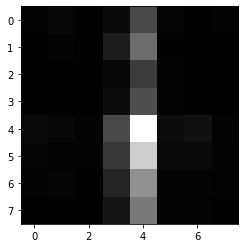

In [43]:
plt.imshow(reconstructed_data, cmap='gray')

torch.Size([1, 8, 8])


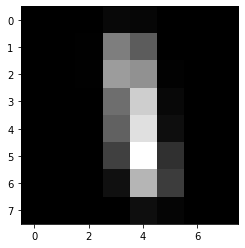

In [44]:
img, label = X_train[1]
print(img.shape)
plt.imshow(img.numpy().reshape(8,8),cmap='gray')

In [60]:
f = 'train_models.csv'
train_models.to_csv(f,index=False)

In [61]:
train_models = pd.read_csv(f,index_col=None)

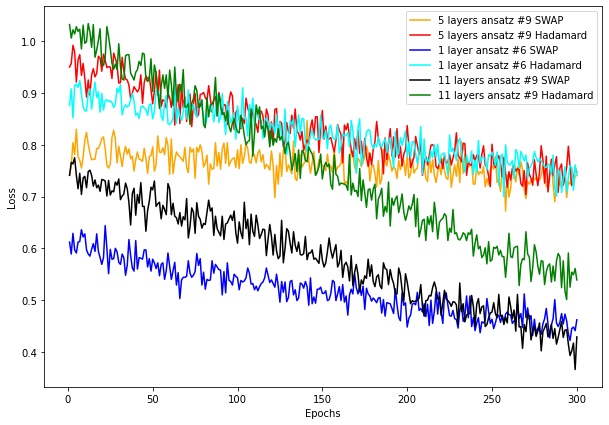

In [62]:
import ast

plt.figure(figsize=(10, 7))
epochs = range(1,301)
plt.plot(epochs, ast.literal_eval(train_models['loss'][0]), color='orange', label='5 layers ansatz #9 SWAP')
plt.plot(epochs, ast.literal_eval(train_models['loss'][1]), color='red', label='5 layers ansatz #9 Hadamard')
plt.plot(epochs, ast.literal_eval(train_models['loss'][2]),color='blue', label='1 layer ansatz #6 SWAP')
plt.plot(epochs, ast.literal_eval(train_models['loss'][3]), color='cyan', label='1 layer ansatz #6 Hadamard')
plt.plot(epochs, ast.literal_eval(train_models['loss'][4]), color='black', label='11 layers ansatz #9 SWAP')
plt.plot(epochs, ast.literal_eval(train_models['loss'][5]), color='green', label='11 layers ansatz #9 Hadamard')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()